## Node embeddings

* Найти набор данных для бинарной классификации рёбер в графе.
  
* Реализовать случайные блуждания алгоритма ```DeepWalk``` и построить множества схожих вершин.
  
* Обучить эмбеддинги вершин, используя ```SGD``` и ```negative sampling```.
  
* Визуализировать эмбеддинги.
  
* Реализовать ```node2vec``` блуждания и обучить классификатор, используя его. Сравнить результаты.

In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from networkx.algorithms.community import girvan_newman
from gensim.models import Word2Vec
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
from datasets import load_dataset

Рассмотрим граф взаимоотношений между известными семьями во Флоренции эпохи Возрождения.

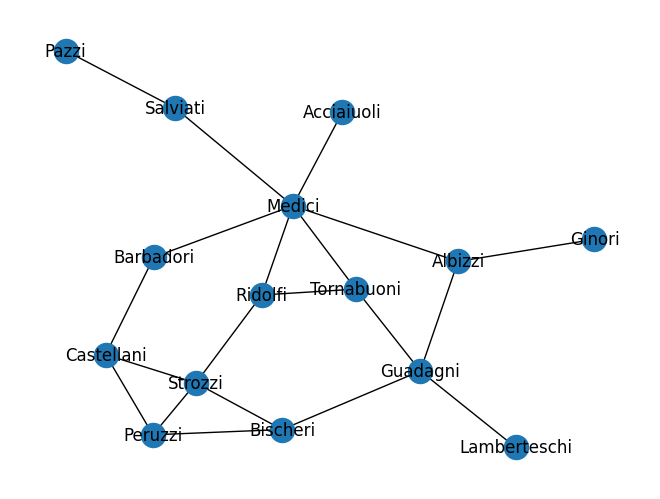

In [14]:
G = nx.florentine_families_graph()
nx.draw(G, with_labels = True)

Применим алгоритм Гирвана-Ньюмана для разделения графа на два сообщества, что позволит использовать результаты для последующей бинарной классификации.

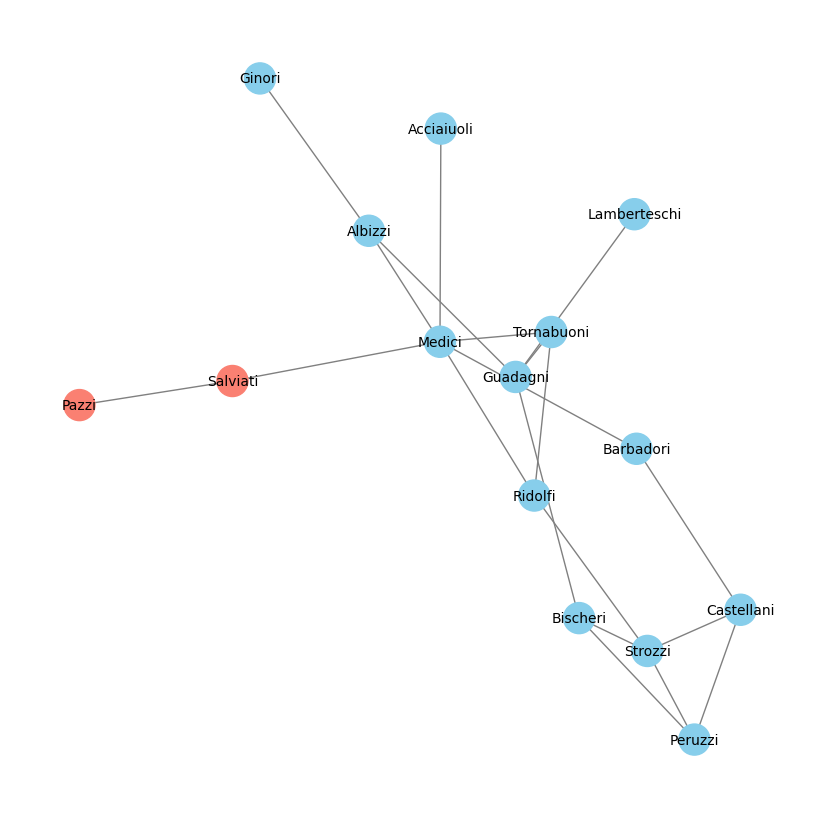

In [17]:
com = next(girvan_newman(G))
g1, g2 = tuple(com)

color_map = []
for node in G.nodes():
    if node in g1:
        color_map.append('skyblue')
    else:
        color_map.append('salmon')

plt.figure(figsize=(8, 8))
nx.draw(
    G,
    node_color=color_map,
    with_labels=True,
    node_size=500,
    font_size=10,
    edge_color='gray'
)
plt.show()

In [8]:
def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    
    for _ in range(walk_length - 1):
        neighbors = list(graph.neighbors(walk[-1]))
        if not neighbors:
            break
        next_node = random.choice(neighbors)
        walk.append(next_node)
    
    return walk

def generate_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(graph, node, walk_length))
    
    return walks

num_walks = 4
walk_length = 7

walks = generate_walks(G, num_walks, walk_length)

for i, w in enumerate(walks):
    print(f"Блуждание {i+1}: {w}")

Блуждание 1: ['Ridolfi', 'Medici', 'Ridolfi', 'Medici', 'Acciaiuoli', 'Medici', 'Ridolfi']
Блуждание 2: ['Lamberteschi', 'Guadagni', 'Tornabuoni', 'Ridolfi', 'Medici', 'Salviati', 'Medici']
Блуждание 3: ['Bischeri', 'Guadagni', 'Lamberteschi', 'Guadagni', 'Tornabuoni', 'Guadagni', 'Bischeri']
Блуждание 4: ['Strozzi', 'Peruzzi', 'Strozzi', 'Peruzzi', 'Strozzi', 'Castellani', 'Strozzi']
Блуждание 5: ['Guadagni', 'Bischeri', 'Guadagni', 'Albizzi', 'Guadagni', 'Lamberteschi', 'Guadagni']
Блуждание 6: ['Peruzzi', 'Bischeri', 'Peruzzi', 'Strozzi', 'Ridolfi', 'Tornabuoni', 'Ridolfi']
Блуждание 7: ['Barbadori', 'Medici', 'Tornabuoni', 'Medici', 'Albizzi', 'Medici', 'Albizzi']
Блуждание 8: ['Pazzi', 'Salviati', 'Medici', 'Ridolfi', 'Tornabuoni', 'Ridolfi', 'Medici']
Блуждание 9: ['Salviati', 'Pazzi', 'Salviati', 'Pazzi', 'Salviati', 'Pazzi', 'Salviati']
Блуждание 10: ['Acciaiuoli', 'Medici', 'Acciaiuoli', 'Medici', 'Acciaiuoli', 'Medici', 'Salviati']
Блуждание 11: ['Castellani', 'Peruzzi', 'Cas

In [19]:
def sample_negative_edges(G, g1, g2, num_neg_samples):
    neg_edge_list = []
    pos_set = set(G.edges())
    
    g1_nodes = list(g1)
    g2_nodes = list(g2)
    
    while len(neg_edge_list) < num_neg_samples:
        if np.random.rand() < 0.5:
            u = np.random.choice(g1_nodes)
            v = np.random.choice(g2_nodes)
        else:
            u = np.random.choice(g2_nodes)
            v = np.random.choice(g1_nodes)
        
        if not G.has_edge(u, v) and (u, v) not in neg_edge_list and (v, u) not in neg_edge_list:
            neg_edge_list.append((u, v))
    
    return neg_edge_list

In [20]:
def edge_list_to_tensor(edge_list, node_to_index):
	edge_index = torch.zeros(2, len(edge_list), dtype=torch.long)
  
	for i, (u, v) in enumerate(edge_list):
		edge_index[0][i] = node_to_index[u]
		edge_index[1][i] = node_to_index[v]

	return edge_index

node_to_index = {node: i for i, node in enumerate(G.nodes())}

pos_edge_list = [(u, v) for u, v in G.edges() if (u in g1 and v in g1) or (u in g2 and v in g2)]
neg_edge_list = sample_negative_edges(G, g1, g2, len(pos_edge_list))

pos_edge_index = edge_list_to_tensor(pos_edge_list, node_to_index)
neg_edge_index = edge_list_to_tensor(neg_edge_list, node_to_index)

In [21]:
def visualize_emb(emb):
    pca = PCA(n_components=2)
    components = pca.fit_transform(emb)

    plt.figure(figsize=(8, 8))
    g1_x = []
    g1_y = []
    g2_x = []
    g2_y = []

    for i, node in enumerate(G.nodes()):
        if node in g1:
            g1_x.append(components[i, 0])
            g1_y.append(components[i, 1])
        else:
            g2_x.append(components[i, 0])
            g2_y.append(components[i, 1])

    plt.scatter(g1_x, g1_y, color="green", label="1")
    plt.scatter(g2_x, g2_y, color="blue", label="2")
    plt.legend()
    plt.show()

In [26]:
def train(emb, train_labels, train_edges, loss_fn, optimizer, G, g1, epochs: int = 300, log_interval: int = 100):
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        emb_u = emb(train_edges[0])
        emb_v = emb(train_edges[1])

        product = torch.sum(emb_u * emb_v, dim=1)
        predictions = torch.sigmoid(product)

        loss = loss_fn(predictions, train_labels)
        loss.backward()
        optimizer.step()

        if epoch % log_interval == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
            
            with torch.no_grad():
                emb_weight = emb.weight.detach().cpu().numpy()
                visualize_emb(emb_weight)

Epoch 1/3000, Loss: 1.2912


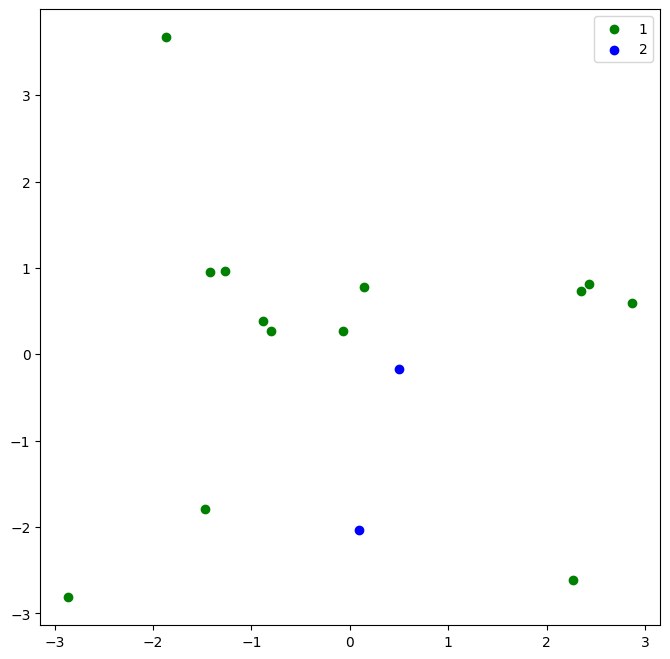

Epoch 101/3000, Loss: 0.1510


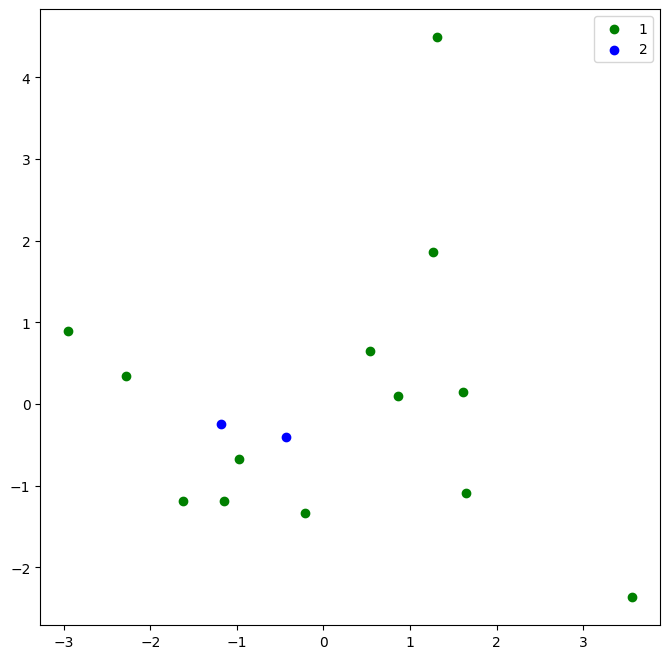

Epoch 201/3000, Loss: 0.0525


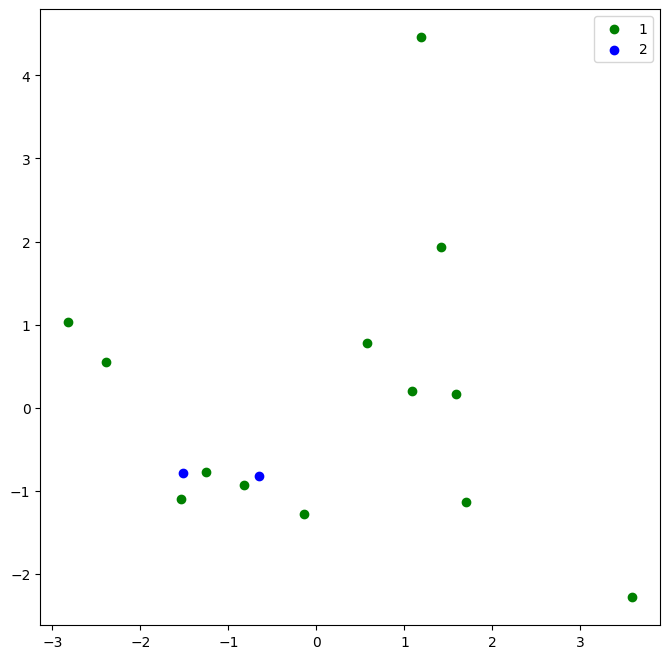

Epoch 301/3000, Loss: 0.0315


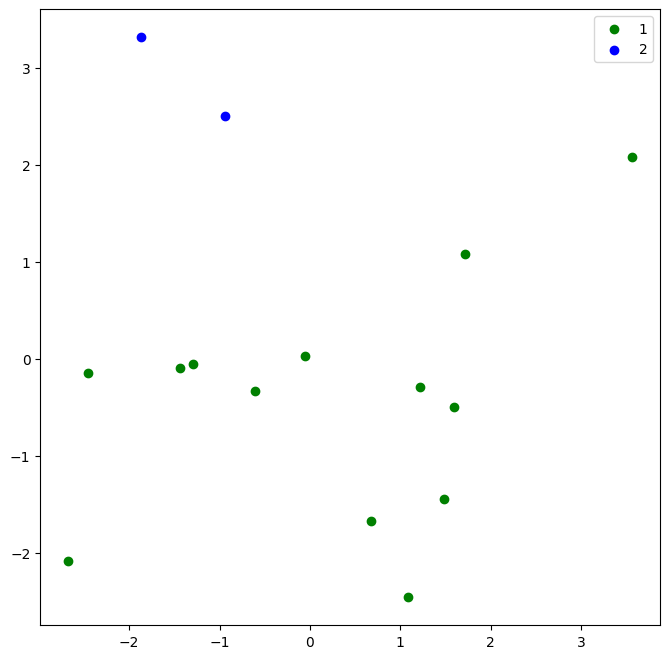

Epoch 401/3000, Loss: 0.0222


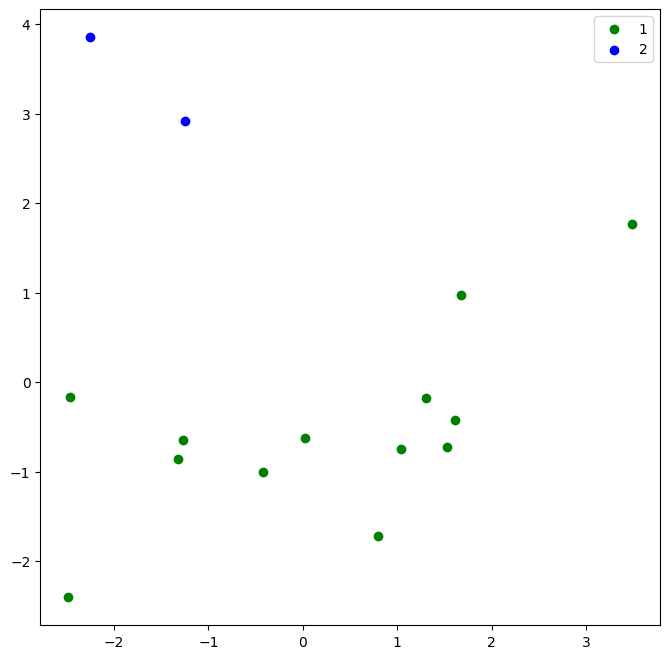

Epoch 501/3000, Loss: 0.0170


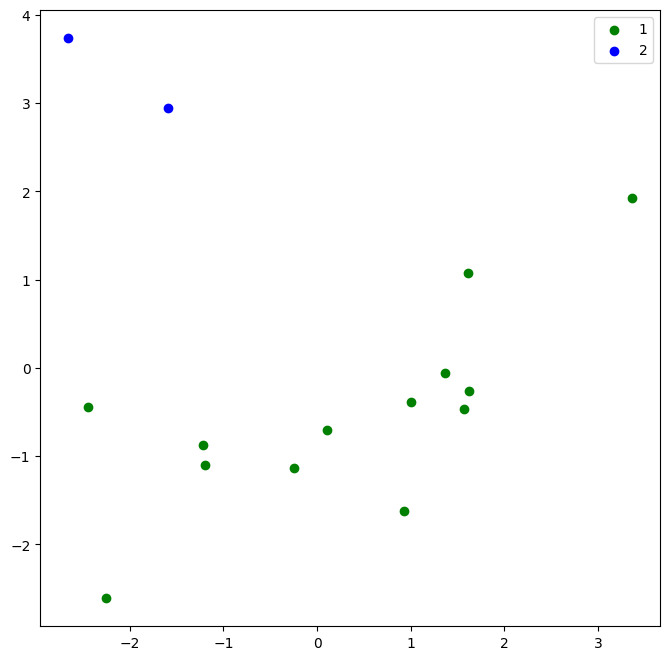

Epoch 601/3000, Loss: 0.0136


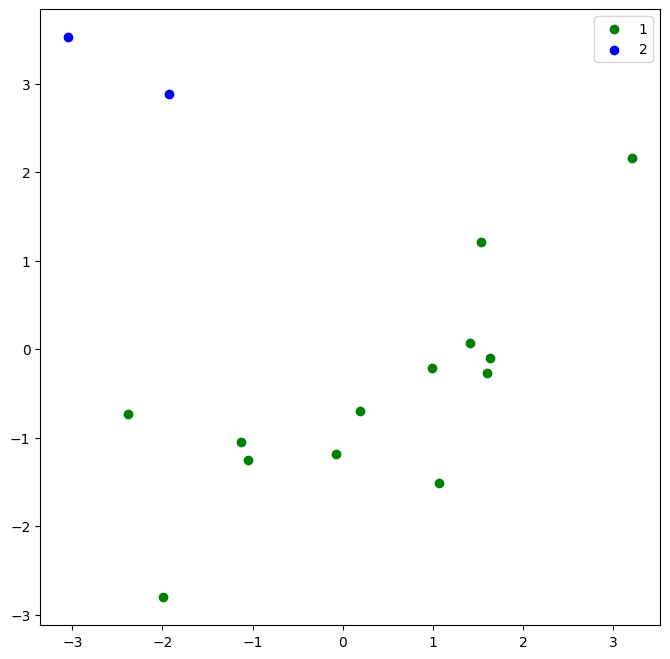

Epoch 701/3000, Loss: 0.0114


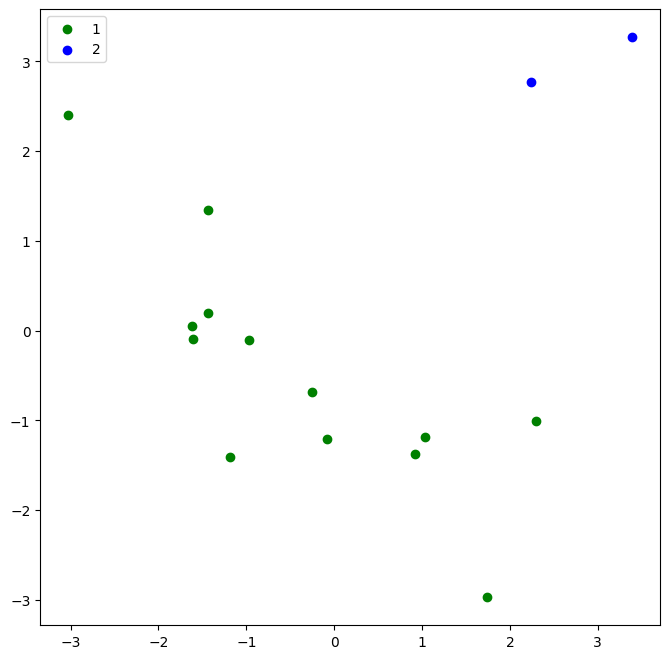

Epoch 801/3000, Loss: 0.0097


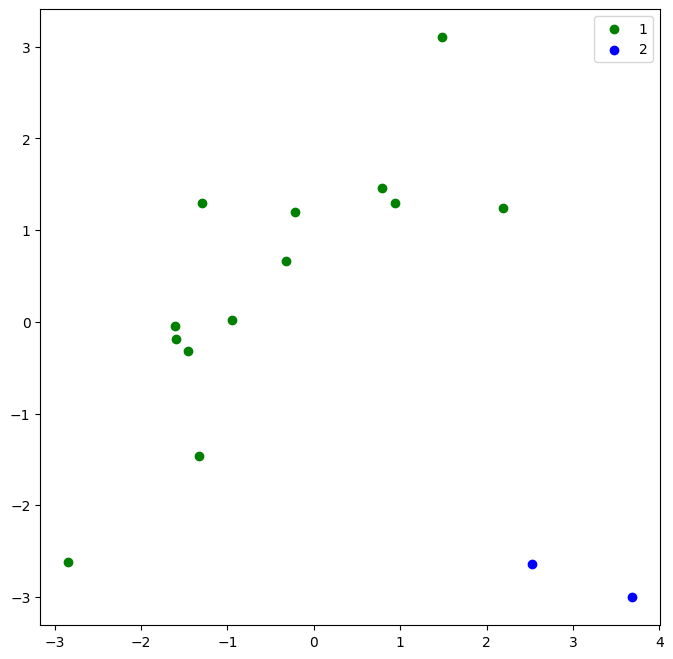

Epoch 901/3000, Loss: 0.0084


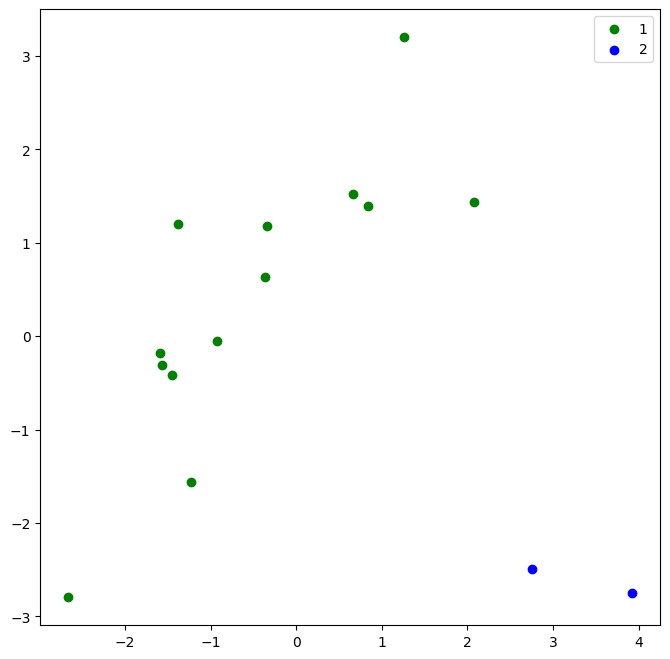

Epoch 1001/3000, Loss: 0.0074


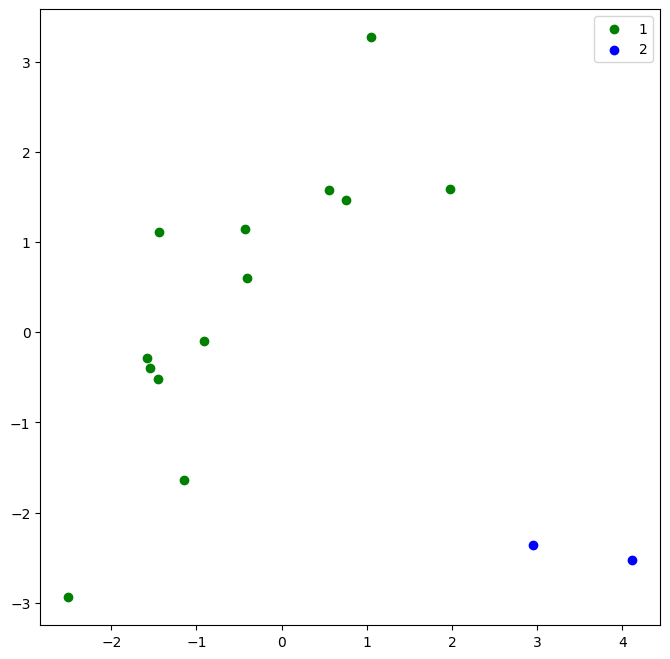

Epoch 1101/3000, Loss: 0.0067


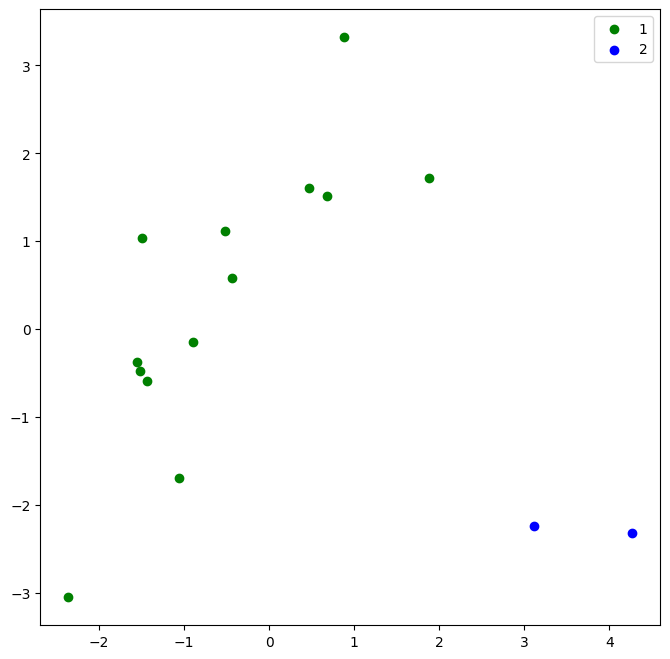

Epoch 1201/3000, Loss: 0.0060


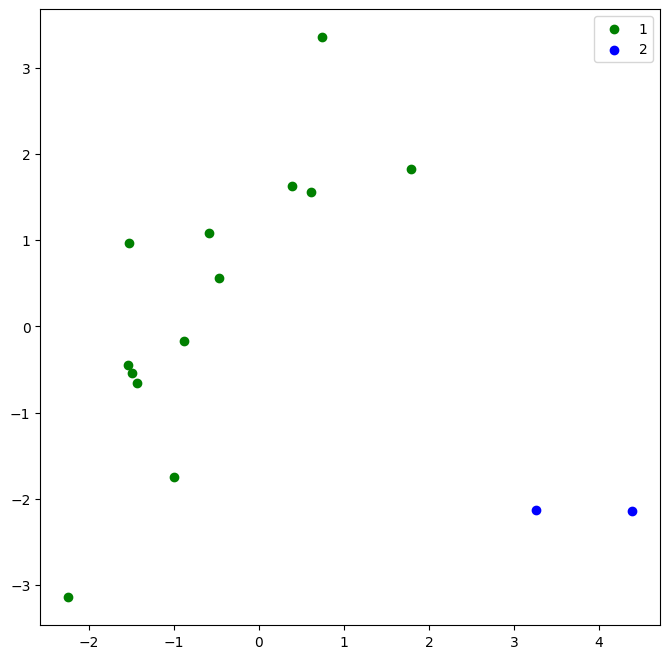

Epoch 1301/3000, Loss: 0.0055


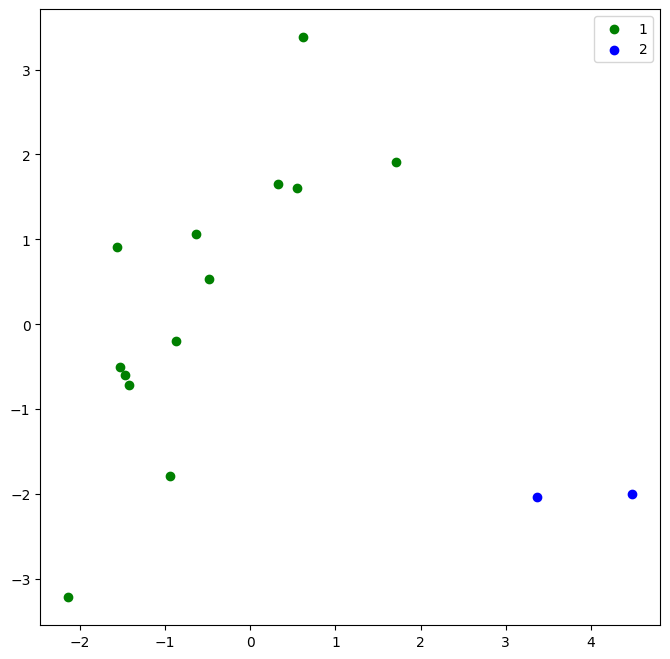

Epoch 1401/3000, Loss: 0.0050


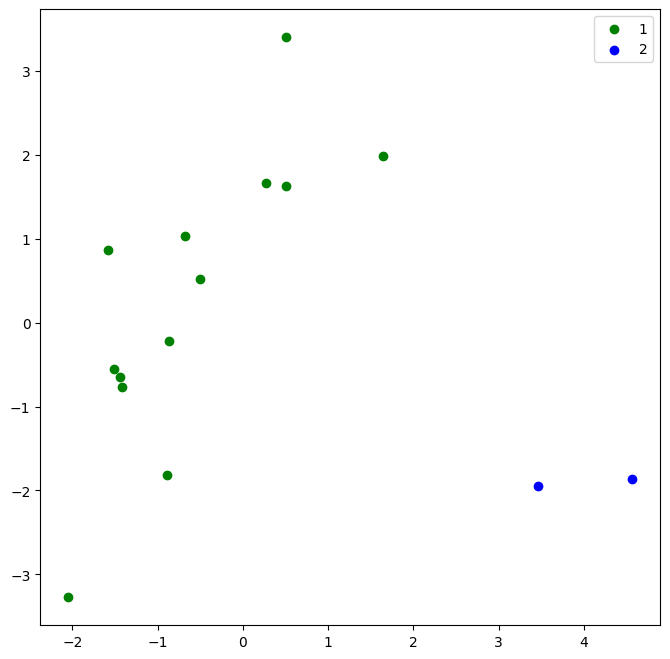

Epoch 1501/3000, Loss: 0.0046


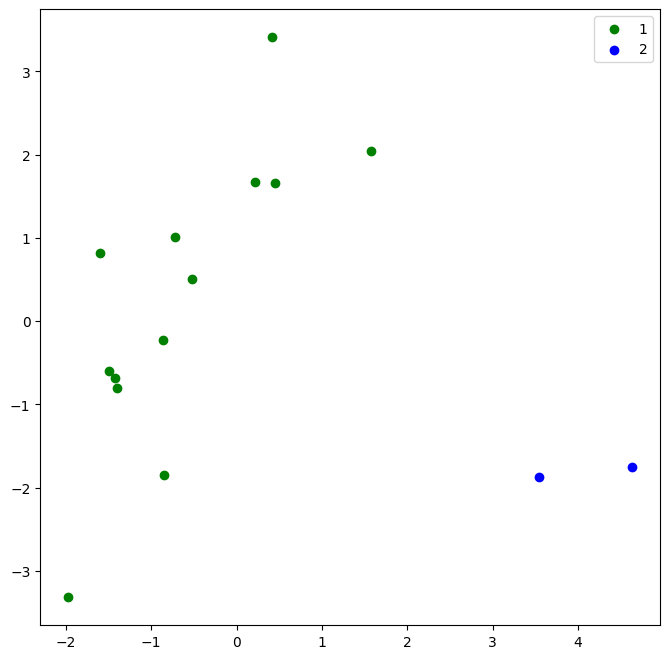

Epoch 1601/3000, Loss: 0.0043


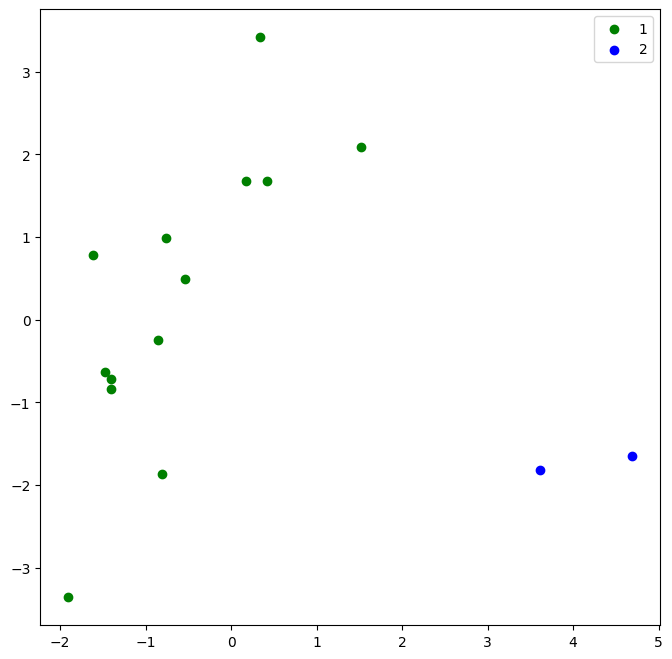

Epoch 1701/3000, Loss: 0.0040


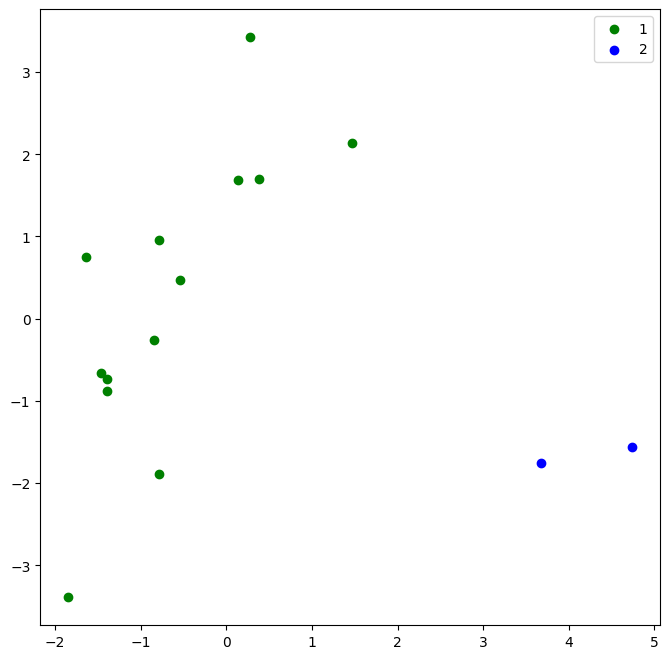

Epoch 1801/3000, Loss: 0.0037


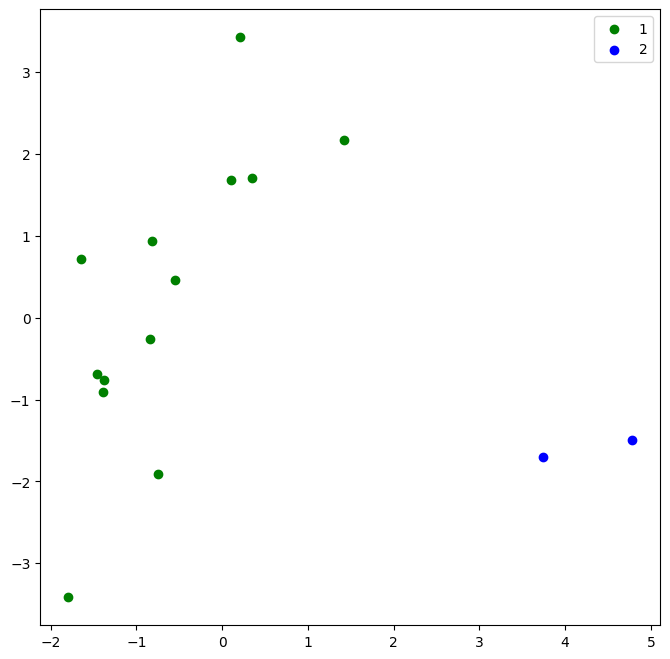

Epoch 1901/3000, Loss: 0.0035


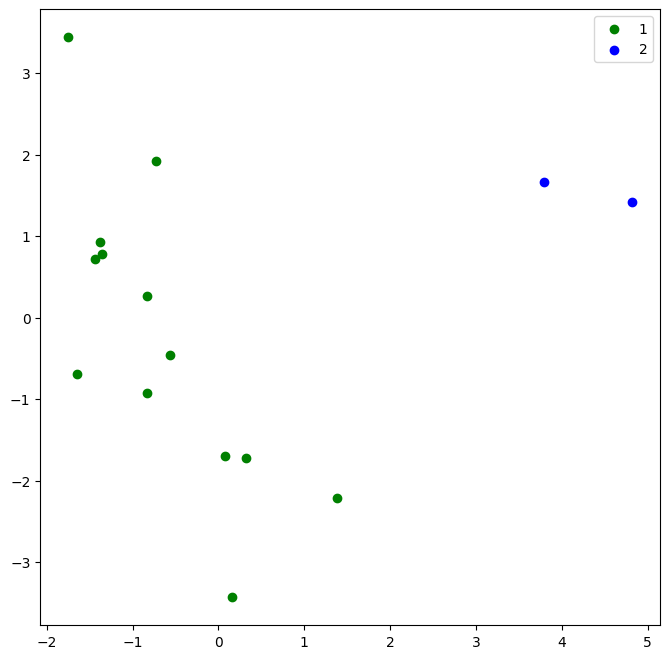

Epoch 2001/3000, Loss: 0.0033


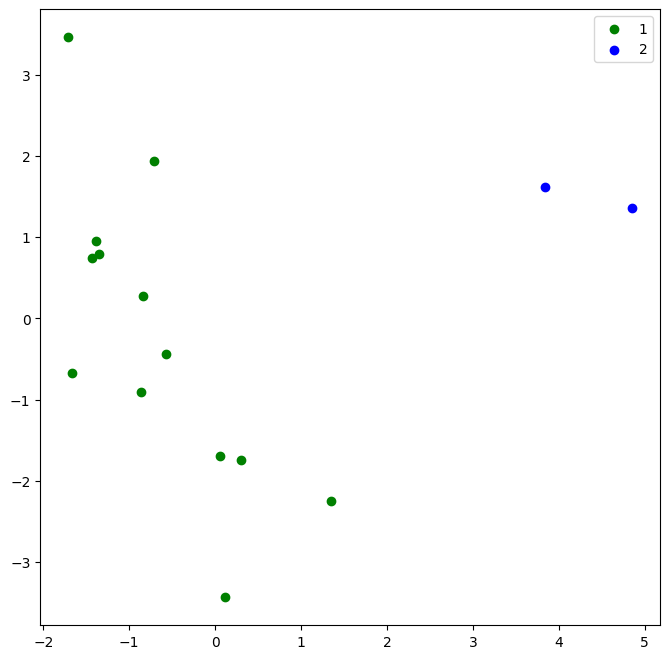

Epoch 2101/3000, Loss: 0.0031


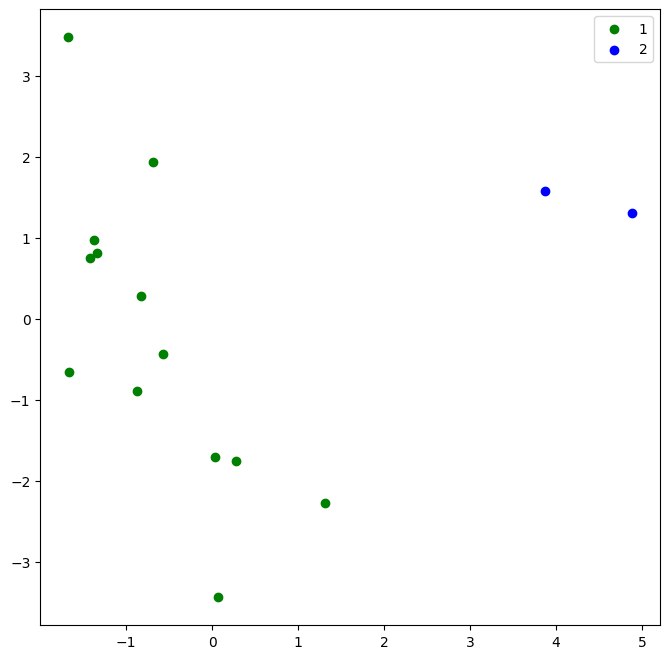

Epoch 2201/3000, Loss: 0.0030


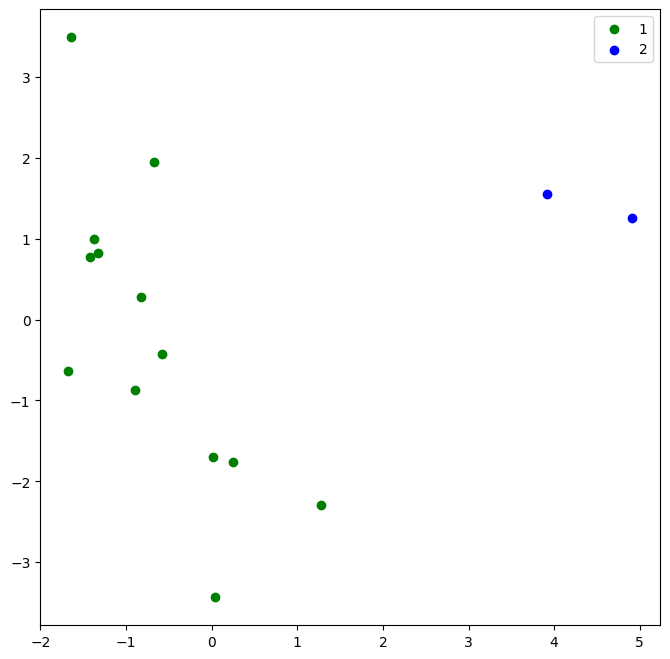

Epoch 2301/3000, Loss: 0.0028


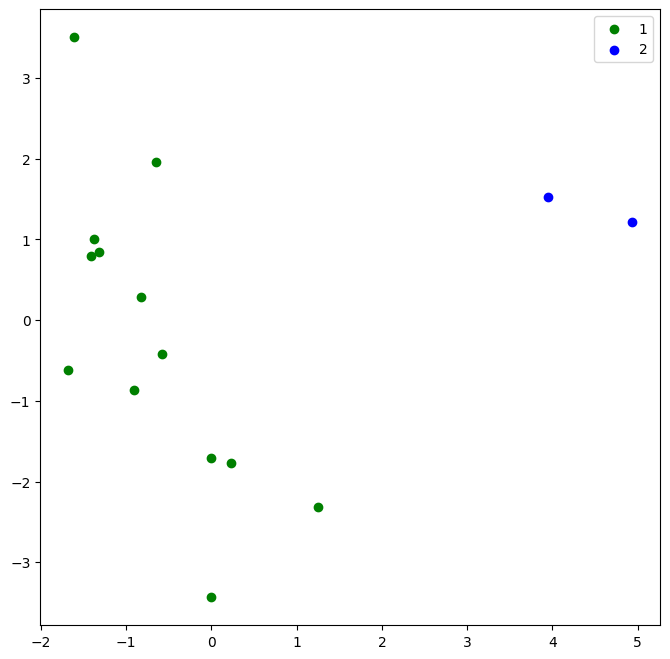

Epoch 2401/3000, Loss: 0.0027


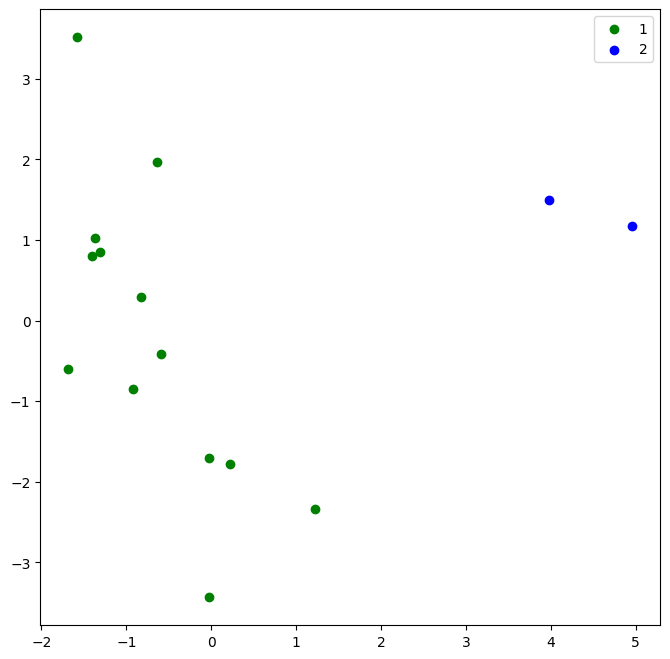

Epoch 2501/3000, Loss: 0.0026


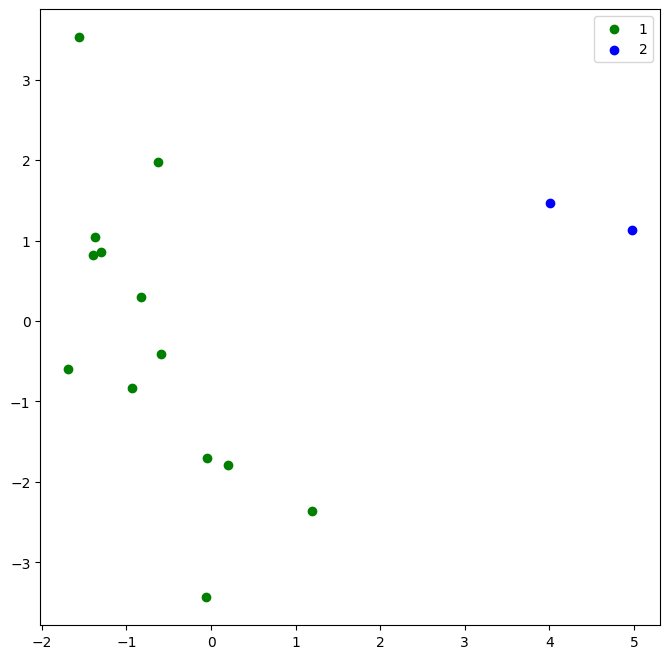

Epoch 2601/3000, Loss: 0.0025


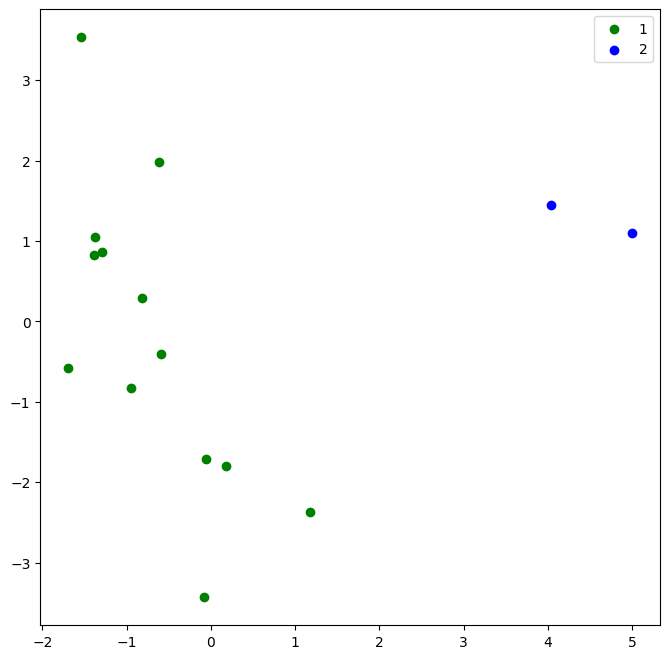

Epoch 2701/3000, Loss: 0.0023


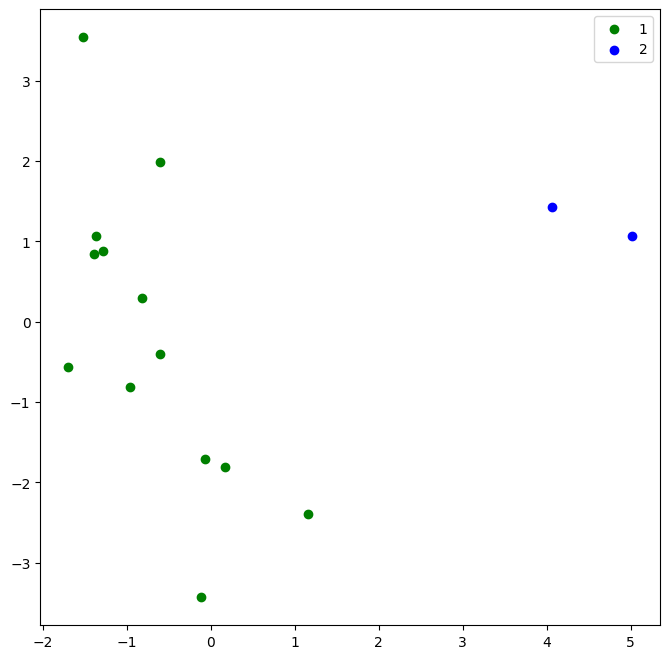

Epoch 2801/3000, Loss: 0.0022


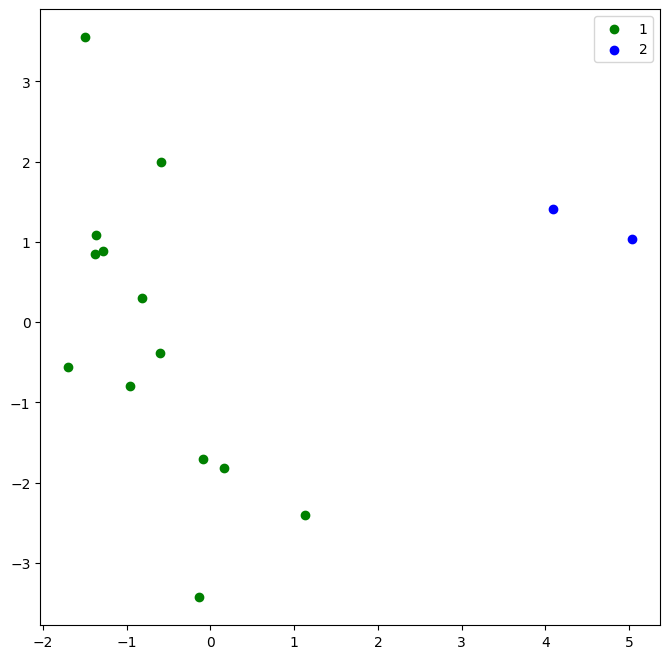

Epoch 2901/3000, Loss: 0.0022


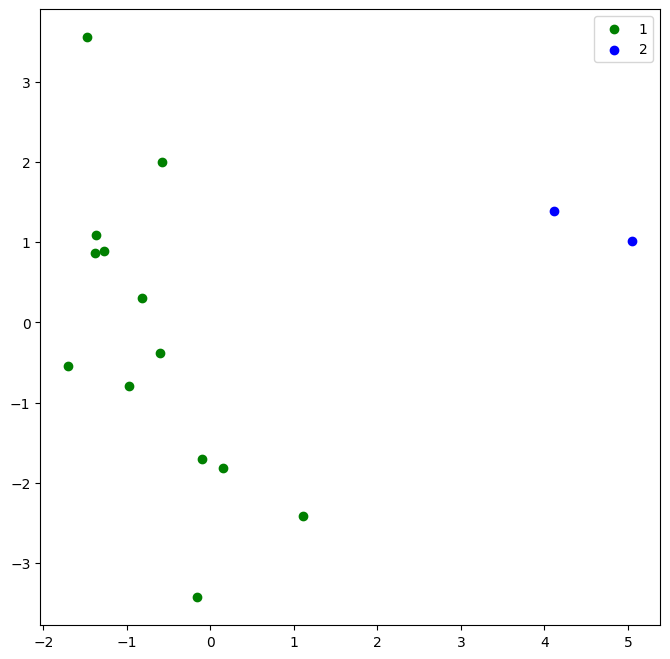

Epoch 3000/3000, Loss: 0.0021


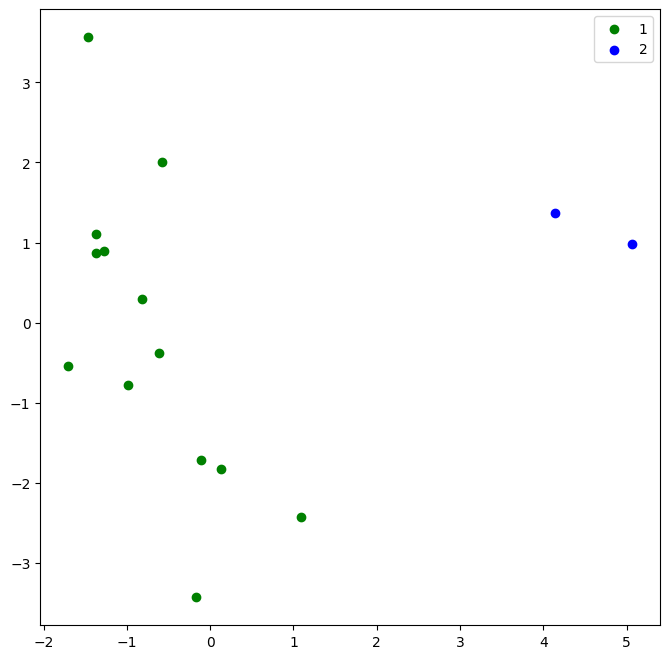

In [28]:
embedding_dim = 16
embedding = nn.Embedding(len(G.nodes()), embedding_dim)

learning_rate = 0.01
optimizer = SGD(embedding.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )
train_label = torch.cat([pos_label, neg_label], dim=0)

train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
epochs = 3000
train(embedding, train_label, train_edge, loss_fn, optimizer, G, g1, epochs=epochs)

Два сообщества разделены достаточно четко после обучения с помощью SGD и negative sampling.

In [34]:
def transition_probabilities(G, prev_node, curr_node, p, q):
    probs = []
    for neighbor in G.neighbors(curr_node):
        if neighbor == prev_node:
            probs.append(1 / p)
        elif G.has_edge(neighbor, prev_node):
            probs.append(1)
        else:
            probs.append(1 / q)
    total = sum(probs)
    return [float(prob) / total for prob in probs]

def node2vec_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]
    
    while len(walk) < walk_length:
        curr_node = walk[-1]
        neighbors = list(G.neighbors(curr_node))
        
        if len(neighbors) == 0:
            break
        
        if len(walk) == 1:
            next_node = random.choice(neighbors)
        else:
            prev_node = walk[-2]
            probs = transition_probabilities(G, prev_node, curr_node, p, q)
            next_node = random.choices(neighbors, weights=probs, k=1)[0]
        
        walk.append(next_node)
    return walk


def generate_node2vec_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = node2vec_walk(G, start_node=node, walk_length=walk_length, p=p, q=q)
            walks.append(walk)
    
    return walks

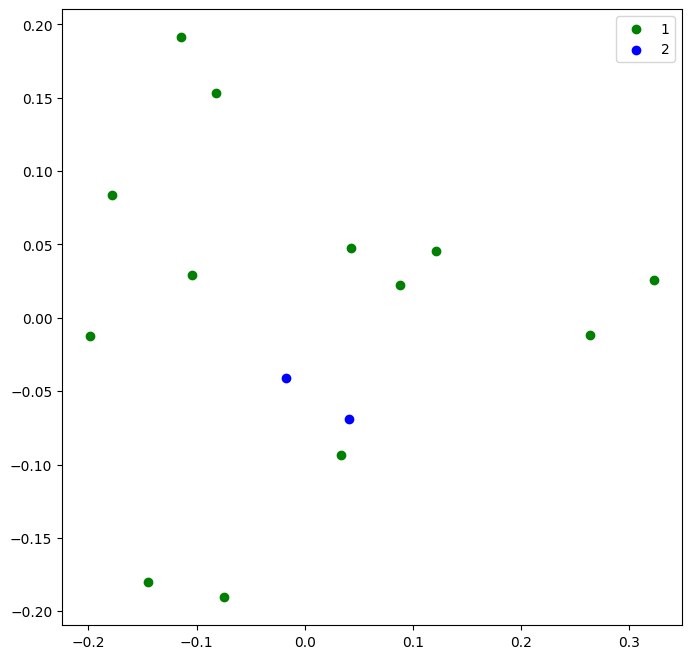

In [51]:
num_walks = 10
walk_length = 16

walks = generate_node2vec_walks(G, num_walks, walk_length, 1, 1)
walks = [[str(node) for node in walk] for walk in walks]

train_word2vec = Word2Vec(sentences=walks, vector_size=7, window=3, min_count=1, sg=1, workers=4)

emb_node = np.array([train_word2vec.wv[str(node)] for node in G.nodes()])

visualize_emb(emb_node)

In [46]:
def train(G, model, g1, g2):
    node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
    labels = np.array([1 if node in g1 else 0 for node in G.nodes()])

    X_train, X_test, y_train, y_test = train_test_split(node_embeddings, labels, test_size=0.3, random_state=42)
    clf = LogisticRegression(solver='lbfgs')
    clf.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, clf.predict(X_test))
    return accuracy
    
accuracy = train(G, train_word2vec, g1, g2)
print(f"Точность: {accuracy:.3f}")

Точность: 0.800


После применения метода ```node2vec``` группы разделены не очень четко, однако это связано, скорее, с малым различием этих двух групп.